##### Задача - построить модель для расчета xG, базируясь на предоставленных данных.
##### Если вы не знаете, что такое xG - это вероятность того, что удар игрока будет голом. 
##### https://www.sports.ru/tribuna/blogs/vadimlukomski/859121.html - это интуитивное объяснение возможной модели. 
 
##### Задание должно быть выполнено в Jupyter Notebook, код должен быть на версии Python 3.4 и выше. Легенда для данных прикреплена вместе с документом. Если вы используете дополнительные библиотеки, кроме стандартных, пожалуйста, опишите явно в начале ноутбука, что вы используете. 
##### Решение должно включать в себя все шаги для корректного построения модели, начиная от предобработки данных, заканчивая шагом predict. Нам очень хотелось бы увидеть, как вы принимаете решения и рассуждаете, поэтому, пожалуйста, комментируйте свой код c помощью Markdown. 
##### Дополнительными плюсами для задания являются визуализации и анализ решения со стороны бизнеса.
 
##### Легенда:
##### event - событие
##### is_goal - результат (гол / не гол)
##### period - период события
##### time - время события в секундах (с начала периода)
##### distance - дистанция броска
##### angle - угол броска (схема)
##### is_rebound - был ли бросок добиванием
##### is_pass_before - был ли бросок после передачи
##### is_cross_line - были ли бросок после пересечения шайбой оси Х (проходи от центра ворот до середины площадки)
##### is_one_touch - был ли бросок в одно касание
##### is_fast_attack - была ли атака без передач назад

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Считаем наш датасет и выведем первые 5 строк по нему

In [2]:
df = pd.read_csv('C:/Datasets/shots.csv', sep = ',')

In [3]:
df['is_goal'].value_counts()

False    13687
True       723
Name: is_goal, dtype: int64

In [4]:
df.head()

,event,is_goal,period,time,distance,angle,is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack
0,Shot Attempt - Wide left,False,1,1071.6,17.4,44.492971,False,False,False,False,False
1,Shot Attempt - Blocked,False,1,519.2,12.9,46.694647,False,False,False,False,False
2,Shot Attempt - Deflected,False,2,742.9,20.6,59.284706,False,False,False,False,False
3,Shot Attempt - Blocked,False,1,210.1,16.6,5.419532,False,True,False,True,False
4,Shot Attempt - Deflected,False,2,599.1,20.1,64.221569,False,False,False,False,False


In [5]:
df.describe()

,period,time,distance,angle
count,14410.000000,14410.000000,14410.000000,14410.000000
mean,2.001319,603.731214,13.490527,56.651537
std,0.825414,350.687775,6.346667,22.474413
min,1.000000,0.400000,0.100000,-90.000000
25%,1.000000,300.050000,9.000000,46.468801
50%,2.000000,599.150000,13.800000,59.569488
75%,3.000000,900.400000,17.800000,72.170266
max,4.000000,2316.500000,58.900000,90.000000


In [6]:
df =  df.applymap(lambda x: 1 if x == True else x)
df =  df.applymap(lambda x: 0 if x == False else x)

### Создадим некоторые новые предикторы на основе имеющихся. Например добавим косинус угла удара по воротам (признак 'angle').
### После этого вычислим расстояние до линии, проходящей через центр ворот (distance*cos(angle)).

In [7]:
df['rad'] = df['angle']/57.297
# df.drop('angle', axis = 1, inplace = True) 
# Для уменьшения мультиколлинеарности нужно удалить признак angle, т.к. он будет линейно зависимым с новым признаком rad.

df['cos_rad'] = np.cos(df['rad'])
df['sin_rad'] = np.sin(df['rad'])
df['distance_center'] = df['cos_rad'] * df['distance']
df['distance_goal'] = df['sin_rad'] * df['distance']

In [8]:
df['angle +'] = np.where(df['angle'] >= 0, 1, 0)

In [9]:
train = df.sample(frac = 0.7, random_state = 200)
test = df.drop(train.index)

In [10]:
for i in ['event', 'period']:
    freq_encoding = train[i].value_counts() / len(train[i])
    train[i + '+' + 'freq'] = train[i].map(freq_encoding)
    test[i + '+' + 'freq'] = test[i].map(freq_encoding)

In [12]:
import seaborn as sns

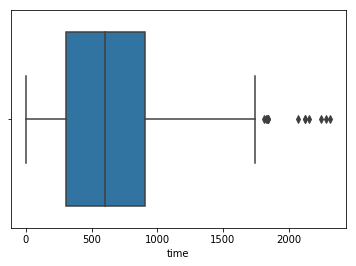

In [13]:
sns.boxplot(train['time'])

In [14]:
bins_time = [0, 130, 580, 700, 970, 1200, np.inf]

# объединение категорий вычислял следующим способом

# train['angle_bins'] = train['angle_bins'].astype('object', copy = False)
#m = []
#n = []
#for i in train['angle_bins'].unique():
    #m.append(i) 
    #n.append(train[(train['angle_bins'] == i) & (train['is_goal'] == 1)]['is_goal'].count() 
          #/ train[(train['angle_bins'] == i) & (train['is_goal'] == 0)]['is_goal'].count())
# k = list(zip(m,n))

# Потом смотрел, какие можно объединить друг с другом

train['time_bins'] = pd.cut(train['time'], bins_time)
test['time_bins'] = pd.cut(test['time'], bins_time)

In [15]:
biv_time = pd.crosstab(train['time_bins'], train['is_goal'])

In [16]:
biv_time

is_goal,0,1
time_bins,,
"(0.0, 130.0]",988,46
"(130.0, 580.0]",3637,214
"(580.0, 700.0]",927,50
"(700.0, 970.0]",2183,101
"(970.0, 1200.0]",1731,111
"(1200.0, inf]",93,6


In [17]:
a= 0.0001
WoE_time = np.log((1.0*biv_time[0]/sum(biv_time[0])+a) / (1.0*biv_time[1]/sum(biv_time[1])+a))
WoE_time

time_bins
(0.0, 130.0]       0.170719
(130.0, 580.0]    -0.063188
(580.0, 700.0]     0.023764
(700.0, 970.0]     0.177108
(970.0, 1200.0]   -0.149141
(1200.0, inf]     -0.153838
dtype: float64

In [18]:
train['time_bins'].unique()

[(700.0, 970.0], (970.0, 1200.0], (0.0, 130.0], (130.0, 580.0], (580.0, 700.0], (1200.0, inf]]
Categories (6, interval[float64]): [(0.0, 130.0] < (130.0, 580.0] < (580.0, 700.0] < (700.0, 970.0] < (970.0, 1200.0] < (1200.0, inf]]

In [19]:
train['time_bins'] = train['time_bins'].astype('str', copy = False)

In [20]:
bins_list_time = ['(0.0, 130.0]', '(130.0, 580.0]', '(580.0, 700.0]', '(700.0, 970.0]', '(970.0, 1200.0]', '(1200.0, inf]']

In [21]:
dict_time = dict(zip(bins_list_time , WoE_time))

In [22]:
train['WOE_time_bins'] = train['time_bins'].map(dict_time)

In [23]:
test['time_bins'] = test['time_bins'].astype('str', copy = False)
test['WOE_time_bins'] = test['time_bins'].map(dict_time)

In [25]:
IV_cat=((1.0*biv_time[0]/sum(biv_time[0])+a) -
 (1.0*biv_time[1]/sum(biv_time[1])+a))*np.log((1.0*biv_time[0]/sum(biv_time[0])+a)
 / (1.0*biv_time[1]/sum(biv_time[1])+a))
IV_cat

time_bins
(0.0, 130.0]       0.002772
(130.0, 580.0]     0.001569
(580.0, 700.0]     0.000054
(700.0, 970.0]     0.006568
(970.0, 1200.0]    0.004346
(1200.0, inf]      0.000251
dtype: float64

In [26]:
bins_angle = [- np.inf, 38, 45, 53, 60, np.inf]

# объединение категорий вычислял следующим способом

# train['angle_bins'] = train['angle_bins'].astype('object', copy = False)
#m = []
#n = []
#for i in train['angle_bins'].unique():
    #m.append(i) 
    #n.append(train[(train['angle_bins'] == i) & (train['is_goal'] == 1)]['is_goal'].count() 
          #/ train[(train['angle_bins'] == i) & (train['is_goal'] == 0)]['is_goal'].count())
# k = list(zip(m,n))

# Потом смотрел, какие можно объединить друг с другом

train['angle_bins'] = pd.cut(train['angle'], bins_angle)
test['angle_bins'] = pd.cut(test['angle'], bins_angle)

In [27]:
biv_angle = pd.crosstab(train['angle_bins'], train['is_goal'])

In [28]:
a= 0.0001
WoE_angle = np.log((1.0*biv_angle[0]/sum(biv_angle[0])+a) / (1.0*biv_angle[1]/sum(biv_angle[1])+a))
WoE_angle

angle_bins
(-inf, 38.0]   -0.331673
(38.0, 45.0]    0.058396
(45.0, 53.0]    0.312167
(53.0, 60.0]    0.470773
(60.0, inf]    -0.066118
dtype: float64

In [29]:
IV_cat=((1.0*biv_angle[0]/sum(biv_angle[0])+a) -
 (1.0*biv_angle[1]/sum(biv_angle[1])+a))*np.log((1.0*biv_angle[0]/sum(biv_angle[0])+a)
 / (1.0*biv_angle[1]/sum(biv_angle[1])+a))
IV_cat

angle_bins
(-inf, 38.0]    0.020756
(38.0, 45.0]    0.000240
(45.0, 53.0]    0.010192
(53.0, 60.0]    0.027904
(60.0, inf]     0.002212
dtype: float64

In [30]:
train['angle_bins'] = train['angle_bins'].astype('str', copy = False)
test['angle_bins'] = test['angle_bins'].astype('str', copy = False)

In [31]:
bins_list_angle = ['(-inf, 38.0]', '(38.0, 45.0]', '(45.0, 53.0]', '(53.0, 60.0]', '(60.0, inf]']

In [32]:
dict_angle = dict(zip(bins_list_angle , WoE_angle))

In [33]:
train['WOE_angle_bins'] = train['angle_bins'].map(dict_angle)
test['WOE_angle_bins'] = test['angle_bins'].map(dict_angle)

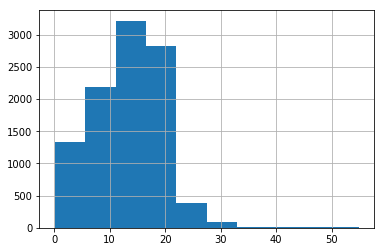

In [34]:
train['distance'].hist()

In [35]:
bins_distance = [0, 3, 6, 9, 15, 18, 22, 100]

# объединение категорий вычислял следующим способом

# train['angle_bins'] = train['angle_bins'].astype('object', copy = False)
#m = []
#n = []
#for i in train['angle_bins'].unique():
    #m.append(i) 
    #n.append(train[(train['angle_bins'] == i) & (train['is_goal'] == 1)]['is_goal'].count() 
          #/ train[(train['angle_bins'] == i) & (train['is_goal'] == 0)]['is_goal'].count())
# k = list(zip(m,n))

# Потом смотрел, какие можно объединить друг с другом

train['distance_bins'] = pd.cut(train['distance'], bins_distance)
test['distance_bins'] = pd.cut(test['distance'], bins_distance)

In [36]:
biv_distance = pd.crosstab(train['distance_bins'], train['is_goal'])

In [37]:
biv_distance

is_goal,0,1
distance_bins,,
"(0, 3]",348,88
"(3, 6]",930,150
"(6, 9]",935,92
"(9, 15]",3196,113
"(15, 18]",1864,42
"(18, 22]",1766,27
"(22, 100]",520,16


In [38]:
a= 0.0001
WoE_distance = np.log((1.0*biv_distance[0]/sum(biv_distance[0])+a) / (1.0*biv_distance[1]/sum(biv_distance[1])+a))
WoE_distance

distance_bins
(0, 3]      -1.519133
(3, 6]      -1.070917
(6, 9]      -0.576936
(9, 15]      0.445957
(15, 18]     0.895925
(18, 22]     1.283081
(22, 100]    0.583640
dtype: float64

In [40]:
IV_cat=((1.0*biv_distance[0]/sum(biv_distance[0])+a) -
 (1.0*biv_distance[1]/sum(biv_distance[1])+a))*np.log((1.0*biv_distance[0]/sum(biv_distance[0])+a)
 / (1.0*biv_distance[1]/sum(biv_distance[1])+a))
IV_cat

distance_bins
(0, 3]       0.197884
(3, 6]       0.200048
(6, 9]       0.044095
(9, 15]      0.053662
(15, 18]     0.103438
(18, 22]     0.171434
(22, 100]    0.014063
dtype: float64

In [41]:
train['distance_bins'] = train['distance_bins'].astype('str', copy = False)
test['distance_bins'] = test['distance_bins'].astype('str', copy = False)

In [42]:
bins_list_distance = ['(0, 3]', '(3, 6]', '(6, 9]', '(9, 15]', '(15, 18]', '(18, 22]', '(22, 100]']

In [43]:
dict_distance = dict(zip(bins_list_distance , WoE_distance))

In [44]:
train['WOE_distance_bins'] = train['distance_bins'].map(dict_distance)
test['WOE_distance_bins'] = test['distance_bins'].map(dict_distance)

In [45]:
cat_list = ['angle_bins', 'distance_bins', 'time_bins', 'event', 'period']

for i in cat_list:
    train[i + ' mean'] = train[i].map(train.groupby(i)['is_goal'].mean())
    test[i + ' mean'] = test[i].map(test.groupby(i)['is_goal'].mean())
    
#train.drop(['angle_bins', 'distance_bins', 'time_bins','event'], axis = 1, inplace = True)
#test.drop(['angle_bins', 'distance_bins', 'time_bins', 'event'], axis = 1, inplace = True)

In [46]:
train.drop('angle', axis = 1, inplace = True)
test.drop('angle', axis = 1, inplace = True)

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10087 entries, 11411 to 11545
Data columns (total 29 columns):
event                 10087 non-null object
is_goal               10087 non-null int64
period                10087 non-null int64
time                  10087 non-null float64
distance              10087 non-null float64
is_rebound            10087 non-null int64
is_pass_before        10087 non-null int64
is_cross_line         10087 non-null int64
is_one_touch          10087 non-null int64
is_fast_attack        10087 non-null int64
rad                   10087 non-null float64
cos_rad               10087 non-null float64
sin_rad               10087 non-null float64
distance_center       10087 non-null float64
distance_goal         10087 non-null float64
angle +               10087 non-null int32
event+freq            10087 non-null float64
period+freq           10087 non-null float64
time_bins             10087 non-null object
WOE_time_bins         10087 non-null float64
angle

In [48]:
train['sum_'] = train.loc[:, 'is_rebound':'is_fast_attack'].sum(axis=1)
test['sum_'] = test.loc[:, 'is_rebound':'is_fast_attack'].sum(axis=1)

train['sum_1,4,5'] = train.loc[:, ['is_rebound', 'is_one_touch', 'is_fast_attack']].sum(axis=1)
test['sum_1,4,5'] = test.loc[:, ['is_rebound', 'is_one_touch', 'is_fast_attack']].sum(axis=1)

train['sum_1,3,5'] = train.loc[:, ['is_rebound', 'is_cross_line', 'is_fast_attack']].sum(axis=1)
test['sum_1,3,5'] = test.loc[:, ['is_rebound', 'is_cross_line', 'is_fast_attack']].sum(axis=1)

train['sum_3,4,5'] = train.loc[:, ['is_one_touch', 'is_cross_line', 'is_fast_attack']].sum(axis=1)
test['sum_3,4,5'] = test.loc[:, ['is_one_touch', 'is_cross_line', 'is_fast_attack']].sum(axis=1)

train['sum_1,2,3'] = train.loc[:, ['is_rebound', 'is_cross_line', 'is_pass_before']].sum(axis=1)
test['sum_1,2,3'] = test.loc[:, ['is_rebound', 'is_cross_line', 'is_pass_before']].sum(axis=1)

In [49]:
train['rad'].replace(0.0, 0.001, inplace = True) # Заменяем 0 на стремящееся к нулю значение

from scipy.stats import boxcox

for i in ['time', 'distance', 'rad', 'cos_rad', 'distance_center']:
    transformed, lam = boxcox(np.absolute(train[i]))
    print('predictor:', i, 'Lambda: %f' % lam)
    if lam < -0.25:
        train[i] = np.sign(train[i]) * (np.absolute(train[i])** (-1/2))
        test[i] = np.sign(test[i]) * (np.absolute(test[i])** (-1/2))
    if -0.25 <= lam <= 0.25:
        train[i] = np.log(np.absolute(train[i])+ 0.001)
        test[i] = np.log(np.absolute(test[i])+ 0.001)
    if 0.25 < lam < 0.75:
        train[i] = np.sign(train[i]) * (np.absolute(train[i])** (1/2))
        test[i] = np.sign(test[i]) * (np.absolute(test[i])** (1/2))

predictor: time Lambda: 0.685768
predictor: distance Lambda: 0.708826
predictor: rad Lambda: 1.354691
predictor: cos_rad Lambda: 0.766999
predictor: distance_center Lambda: 0.517407


In [50]:
y_train = train['is_goal']
train.drop('is_goal', axis=1, inplace = True)

y_test = test['is_goal']
test.drop('is_goal', axis=1, inplace = True)

In [51]:
train_dummies = pd.get_dummies(train)
test_dummies = pd.get_dummies(test)

In [52]:
for i in ['event', 'time_bins', 'angle_bins', 'distance_bins']:
    train[i] = train[i].astype('str', copy = False)
    test[i] = test[i].astype('str', copy = False)

In [53]:
train_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10087 entries, 11411 to 11545
Data columns (total 58 columns):
period                                10087 non-null int64
time                                  10087 non-null float64
distance                              10087 non-null float64
is_rebound                            10087 non-null int64
is_pass_before                        10087 non-null int64
is_cross_line                         10087 non-null int64
is_one_touch                          10087 non-null int64
is_fast_attack                        10087 non-null int64
rad                                   10087 non-null float64
cos_rad                               10087 non-null float64
sin_rad                               10087 non-null float64
distance_center                       10087 non-null float64
distance_goal                         10087 non-null float64
angle +                               10087 non-null int32
event+freq                            10087 non

In [54]:
test.isnull().sum()

event                 0
period                0
time                  0
distance              0
is_rebound            0
is_pass_before        0
is_cross_line         0
is_one_touch          0
is_fast_attack        0
rad                   0
cos_rad               0
sin_rad               0
distance_center       0
distance_goal         0
angle +               0
event+freq            0
period+freq           0
time_bins             0
WOE_time_bins         0
angle_bins            0
WOE_angle_bins        0
distance_bins         0
WOE_distance_bins     0
angle_bins mean       0
distance_bins mean    0
time_bins mean        0
event mean            0
period mean           0
sum_                  0
sum_1,4,5             0
sum_1,3,5             0
sum_3,4,5             0
sum_1,2,3             0
dtype: int64

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(train_dummies)

train_s = scaler.transform(train_dummies)
test_s = scaler.transform(test_dummies)

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

logreg_grid = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'liblinear')

param_grid = {'max_iter': [50, 80, 100, 120, 200, 300, 400, 500]} # Задаем решетку гиперпараметров. 

stratcv = StratifiedKFold(n_splits=10) # Указываем количество блоков для кросс-валидации.

#создаем экземпляр класса GridSearchCV
grid_search = GridSearchCV(logreg_grid, param_grid, 
                           scoring='roc_auc', 
                           n_jobs=-1, cv=stratcv)

grid_search.fit(train_s, y_train)

test_score = roc_auc_score(y_test, grid_search.predict_proba(test_s)[:, 1])
 #смотрим результаты GridSearchCV
print('AUC на тестовой выборке: {:.3f}'.format(test_score))
print('Наилучшее значение гиперпараметров: {}'.format(grid_search.best_params_))
print('Наилучшее значение AUC: {:.3f}'.format(grid_search.best_score_))

AUC на тестовой выборке: 0.839
Наилучшее значение гиперпараметров: {'max_iter': 50}
Наилучшее значение AUC: 0.847


In [57]:
import xgboost as XGB
Boost = XGB.XGBClassifier(n_jobs=-1, reg_alpha = 5, reg_lambda = 0.1,
                          min_samples_leaf = 2, min_samples_split = 5, max_depth = 3, n_estimators = 700, learning_rate = 0.01,
                          subsample = 0.9)

param_grid = {'colsample_bylevel' : [0.6, 0.7, 0.8, 0.9], 'colsample_bytree' : [0.6, 0.7, 0.8, 0.9]}

stratcv = StratifiedKFold(n_splits=3) 


grid_search = GridSearchCV(Boost, param_grid, 
                           scoring='roc_auc', 
                           n_jobs=-1, cv=stratcv)

grid_search.fit(train_s, y_train)

test_score = roc_auc_score(y_test, grid_search.predict_proba(test_s)[:, 1])

print('AUC на тестовой выборке: {:.3f}'.format(test_score))
print('Наилучшее значение гиперпараметров: {}'.format(grid_search.best_params_))
print('Наилучшее значение AUC: {:.3f}'.format(grid_search.best_score_))

AUC на тестовой выборке: 0.846
Наилучшее значение гиперпараметров: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9}
Наилучшее значение AUC: 0.855


In [70]:
# После подбора параметров, обучим нашу модель бустинга
Boost_1 = XGB.XGBClassifier(n_jobs=-1, reg_alpha = 5, reg_lambda = 0.1,
                          min_samples_leaf = 2, min_samples_split = 5, max_depth = 3, n_estimators = 700, learning_rate = 0.01,
                          subsample = 0.9, colsample_bylevel = 0.9, colsample_bytree = 0.9)

Boost_1.fit(train_s, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, min_samples_leaf=2,
       min_samples_split=5, missing=None, n_estimators=700, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=5, reg_lambda=0.1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [66]:
from xgboost import plot_importance

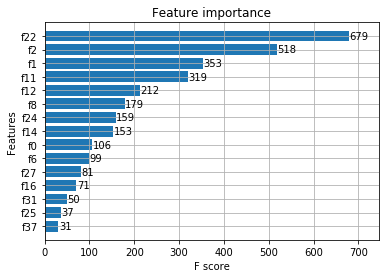

In [88]:
XGB.plot_importance(Boost_1, max_num_features=15, height=0.8)

In [85]:
feat_labels = train.columns
# записываем важности
importances =  Boost_1.feature_importances_
# сортирум важности по убыванию
indices = np.argsort(importances)[::-1]
# сопоставляем важности названиям предикторов
for f in range(train.shape[1]):
    print('%2d) %-*s %f' % (f + 1, 35,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) WOE_distance_bins                   0.201364
 2) time                                0.153618
 3) period                              0.104686
 4) sin_rad                             0.094603
 5) distance_center                     0.062871
 6) is_fast_attack                      0.053084
 7) distance_bins mean                  0.047153
 8) angle +                             0.045374
 9) event                               0.031435
10) is_cross_line                       0.029359
11) period mean                         0.024021
12) period+freq                         0.021056
13) sum_3,4,5                           0.014828
14) time_bins mean                      0.010973


IndexError: index 37 is out of bounds for axis 0 with size 33